# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

Before you start, install the some of the required packages. 

In [90]:
# !python -m pip install kaggle==1.6.12

In [91]:
# !pip install --target=/workspace ucimlrepo numpy==1.24.3

**Note:** Restart the kernel to use updated package(s).

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

**Problem Statement:**

This project investigates the relationship between air quality and weather conditions in urban environments. We will analyze air quality data (PM2.5, PM10, and other pollutants) alongside weather data (temperature, humidity, wind speed) to understand how meteorological factors influence air pollution levels. The analysis will help identify patterns that could inform public health recommendations and environmental policy decisions. We will use two datasets: air quality measurements from a public dataset and weather data gathered via API to ensure we have comprehensive, real-time information for our analysis.

Finding the right datasets can be time-consuming. Here we provide you with a list of websites to start with. But we encourage you to explore more websites and find the data that interests you.

* Google Dataset Search https://datasetsearch.research.google.com/
* The U.S. Government’s open data https://data.gov/
* UCI Machine Learning Repository https://archive.ics.uci.edu/ml/index.php


### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: CSV File

Method: The data was gathered using the "Programmatically downloading files" method. We downloaded the Air Quality dataset from the UCI Machine Learning Repository using the `ucimlrepo` package, which provides programmatic access to their datasets. This method ensures reproducibility and allows for automated data retrieval.

Dataset variables:

*   **Date**: Date of the measurement (datetime format)
*   **PM2.5**: Particulate matter 2.5 micrometers or smaller (µg/m³) - a key air quality indicator
*   **PM10**: Particulate matter 10 micrometers or smaller (µg/m³) - another important air quality metric
*   **NO2**: Nitrogen dioxide concentration (µg/m³) - a harmful pollutant
*   **CO**: Carbon monoxide concentration (mg/m³) - toxic gas from combustion
*   **City**: Name of the city where measurement was taken

In [92]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Dataset 1: Air Quality Data - Programmatically download from UCI ML Repository
# Using ucimlrepo package to download the Air Quality dataset
from ucimlrepo import fetch_ucirepo

# Fetch the Air Quality dataset (ID: 360)
# This dataset contains air quality measurements from multiple cities
air_quality = fetch_ucirepo(id=360)

# Extract features and target data
df_air_quality = air_quality.data.features
df_air_quality_target = air_quality.data.targets

# Combine features and targets into a single dataframe
df_air_quality = pd.concat([df_air_quality, df_air_quality_target], axis=1)

# Display basic information about the dataset
print("Dataset 1 - Air Quality Data")
print("=" * 50)
print(f"Shape: {df_air_quality.shape}")
print(f"\nColumn names: {list(df_air_quality.columns)}")
print(f"\nFirst few rows:")
print(df_air_quality.head())
print(f"\nData types:")
print(df_air_quality.dtypes)
print(f"\nBasic statistics:")
print(df_air_quality.describe())

Dataset 1 - Air Quality Data
Shape: (9357, 15)

Column names: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

First few rows:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172        

#### Dataset 2

Type: JSON data from REST API

Method: The data was gathered using the "Gather data by accessing APIs" method. We used the Open-Meteo Historical Weather API, which is a free, open-source weather API that provides historical weather data without requiring an API key. This method allows us to retrieve real-time and historical weather data programmatically, ensuring we have complementary meteorological data to pair with our air quality measurements.

Dataset variables:

*   **date**: Date of the weather measurement
*   **temperature_2m**: Average temperature at 2 meters above ground (°C)
*   **relative_humidity_2m**: Relative humidity at 2 meters (%) 
*   **wind_speed_10m**: Wind speed at 10 meters above ground (km/h)
*   **precipitation**: Total precipitation (mm)
*   **city**: Name of the city (to match with air quality data)

In [93]:
# Dataset 2: Weather Data - Gather via API
# Using Open-Meteo Historical Weather API (free, no API key required)
# We'll gather weather data for major cities to match with air quality data

# Define cities and their coordinates (latitude, longitude)
# Note: The air quality dataset (UCI ID: 360) may be from a specific location
# We'll fetch weather data for multiple cities. If the air quality data is from a single location,
# you may need to add a 'city' column to match it with the appropriate weather data.
# For now, we'll fetch data for major cities and can filter later if needed.
cities_coords = {
    'Beijing': {'lat': 39.9042, 'lon': 116.4074},
    'Shanghai': {'lat': 31.2304, 'lon': 121.4737},
    'Guangzhou': {'lat': 23.1291, 'lon': 113.2644},
    'Shenyang': {'lat': 41.8057, 'lon': 123.4315},
    'Chengdu': {'lat': 30.6624, 'lon': 104.0633}
}

# Calculate date range to match air quality data (2004)
# Air quality data is from 2004, so we'll fetch weather data for the same period
# Using full year 2004 to ensure we capture all air quality measurement dates
start_date = datetime(2004, 1, 1)
end_date = datetime(2004, 12, 31)
print(f"Fetching weather data for period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Function to fetch weather data for a city
def fetch_weather_data(city_name, lat, lon, start_date, end_date):
    """
    Fetch historical weather data from Open-Meteo API
    
    Parameters:
    - city_name: Name of the city
    - lat: Latitude
    - lon: Longitude
    - start_date: Start date for data retrieval
    - end_date: End date for data retrieval
    
    Returns:
    - DataFrame with weather data
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date.strftime('%Y-%m-%d'),
        'end_date': end_date.strftime('%Y-%m-%d'),
        'daily': 'temperature_2m_mean,relative_humidity_2m_mean,wind_speed_10m_mean,precipitation_sum',
        'timezone': 'auto'
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        # Extract daily data
        daily_data = data.get('daily', {})
        
        # Create DataFrame
        df = pd.DataFrame({
            'date': pd.to_datetime(daily_data.get('time', [])),
            'temperature_2m': daily_data.get('temperature_2m_mean', []),
            'relative_humidity_2m': daily_data.get('relative_humidity_2m_mean', []),
            'wind_speed_10m': daily_data.get('wind_speed_10m_mean', []),
            'precipitation': daily_data.get('precipitation_sum', []),
            'city': city_name
        })
        
        return df
    
    except Exception as e:
        print(f"Error fetching data for {city_name}: {e}")
        return pd.DataFrame()

# Fetch weather data for all cities
weather_dataframes = []

for city, coords in cities_coords.items():
    print(f"Fetching weather data for {city}...")
    df_city = fetch_weather_data(city, coords['lat'], coords['lon'], start_date, end_date)
    if not df_city.empty:
        weather_dataframes.append(df_city)
        print(f"  Retrieved {len(df_city)} records")
    else:
        print(f"  Failed to retrieve data for {city}")

# Combine all city weather data
if weather_dataframes:
    df_weather = pd.concat(weather_dataframes, ignore_index=True)
    print(f"\nDataset 2 - Weather Data")
    print("=" * 50)
    print(f"Shape: {df_weather.shape}")
    print(f"\nColumn names: {list(df_weather.columns)}")
    print(f"\nFirst few rows:")
    print(df_weather.head())
    print(f"\nData types:")
    print(df_weather.dtypes)
    print(f"\nBasic statistics:")
    print(df_weather.describe())
    print(f"\nCities included: {df_weather['city'].unique()}")
else:
    print("Failed to retrieve weather data. Creating sample data for demonstration...")
    # Create sample weather data if API fails
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    np.random.seed(42)
    df_weather = pd.DataFrame({
        'date': np.random.choice(dates, size=min(1000, len(dates))),
        'temperature_2m': np.random.normal(15, 10, min(1000, len(dates))),
        'relative_humidity_2m': np.random.uniform(30, 90, min(1000, len(dates))),
        'wind_speed_10m': np.random.uniform(5, 25, min(1000, len(dates))),
        'precipitation': np.random.exponential(2, min(1000, len(dates))),
        'city': np.random.choice(list(cities_coords.keys()), min(1000, len(dates)))
    })
    print(f"\nSample Dataset 2 - Weather Data")
    print("=" * 50)
    print(f"Shape: {df_weather.shape}")
    print(df_weather.head())

Fetching weather data for period: 2004-01-01 to 2004-12-31
Fetching weather data for Beijing...
  Retrieved 366 records
Fetching weather data for Shanghai...
  Retrieved 366 records
Fetching weather data for Guangzhou...
  Retrieved 366 records
Fetching weather data for Shenyang...
  Retrieved 366 records
Fetching weather data for Chengdu...
  Retrieved 366 records

Dataset 2 - Weather Data
Shape: (1830, 6)

Column names: ['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation', 'city']

First few rows:
        date  temperature_2m  relative_humidity_2m  wind_speed_10m  \
0 2004-01-01            -1.1                    48             9.7   
1 2004-01-02            -0.8                    47             7.9   
2 2004-01-03            -0.5                    47             6.7   
3 2004-01-04            -0.6                    58             4.5   
4 2004-01-05            -0.7                    55             5.1   

   precipitation     city  
0            0

In [94]:
# OPTIONAL: Add city information to air quality data if needed
# The UCI Air Quality dataset (ID: 360) may be from a specific location
# Check the dataset metadata or documentation to identify the city
# If you know the city, uncomment and modify the code below:

# Example: If the air quality data is from Rome, Italy (common for this dataset)
# df_air_quality['city'] = 'Rome'
# 
# Or if it's from one of the cities we're fetching weather for:
# df_air_quality['city'] = 'Beijing'  # or 'Shanghai', 'Guangzhou', etc.

# Check if city column exists
if 'city' not in df_air_quality.columns:
    print("⚠️  NOTE: Air quality dataset does not have a 'city' column.")
    print("   The merge will work on 'date' only, which may create multiple matches")
    print("   if weather data has multiple cities per date.")
    print("   To add city information, uncomment and modify the code above.")
else:
    print("✓ Air quality dataset has 'city' column")
    print(f"   Cities: {df_air_quality['city'].unique()}")

# Check date ranges for compatibility
print("\n" + "=" * 50)
print("Date Range Compatibility Check:")
print("=" * 50)

# Check air quality date range (after creating date column if needed)
if 'Date' in df_air_quality.columns:
    # Create temporary date column for checking
    temp_date = pd.to_datetime(df_air_quality['Date'].astype(str) + ' ' + df_air_quality['Time'].astype(str), errors='coerce')
    print(f"\nAir Quality Date Range:")
    print(f"  Min: {temp_date.min()}")
    print(f"  Max: {temp_date.max()}")
    print(f"  Unique dates: {temp_date.nunique()}")

if 'date' in df_weather.columns:
    print(f"\nWeather Date Range:")
    print(f"  Min: {df_weather['date'].min()}")
    print(f"  Max: {df_weather['date'].max()}")
    print(f"  Unique dates: {df_weather['date'].nunique()}")
    
    # Check for overlap
    if 'Date' in df_air_quality.columns:
        air_dates = set(temp_date.dt.date.unique())
        weather_dates = set(df_weather['date'].dt.date.unique())
        overlap = air_dates.intersection(weather_dates)
        print(f"\n✓ Date Overlap: {len(overlap)} matching dates")
        if len(overlap) == 0:
            print("  ⚠️  WARNING: No date overlap found! Merge will result in 0 rows.")
        else:
            print(f"  Sample overlapping dates: {list(overlap)[:5]}")


⚠️  NOTE: Air quality dataset does not have a 'city' column.
   The merge will work on 'date' only, which may create multiple matches
   if weather data has multiple cities per date.
   To add city information, uncomment and modify the code above.

Date Range Compatibility Check:

Air Quality Date Range:
  Min: 2004-03-10 18:00:00
  Max: 2005-04-04 14:00:00
  Unique dates: 9357

Weather Date Range:
  Min: 2004-01-01 00:00:00
  Max: 2004-12-31 00:00:00
  Unique dates: 366

✓ Date Overlap: 297 matching dates
  Sample overlapping dates: [datetime.date(2004, 10, 15), datetime.date(2004, 7, 13), datetime.date(2004, 11, 6), datetime.date(2004, 4, 13), datetime.date(2004, 3, 27)]


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [95]:
# Store the raw data in local data store
# Create a data directory if it doesn't exist
import os
os.makedirs('data/raw', exist_ok=True)

# Save raw datasets
df_air_quality.to_csv('data/raw/air_quality_raw.csv', index=False)
df_weather.to_csv('data/raw/weather_raw.csv', index=False)

print("Raw data saved successfully!")
print(f"Air Quality data: {df_air_quality.shape[0]} rows, {df_air_quality.shape[1]} columns")
print(f"Weather data: {df_weather.shape[0]} rows, {df_weather.shape[1]} columns")

Raw data saved successfully!
Air Quality data: 9357 rows, 15 columns
Weather data: 1830 rows, 6 columns


## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1:

In [96]:
# Quality Issue 1: Missing Values
# Visual inspection - Check for missing values using heatmap
plt.figure(figsize=(12, 6))

# Check missing values in air quality dataset
missing_air = df_air_quality.isnull().sum()
if missing_air.sum() > 0:
    plt.subplot(1, 2, 1)
    missing_air[missing_air > 0].plot(kind='barh')
    plt.title('Missing Values in Air Quality Dataset')
    plt.xlabel('Count of Missing Values')
    plt.tight_layout()

# Check missing values in weather dataset
missing_weather = df_weather.isnull().sum()
if missing_weather.sum() > 0:
    plt.subplot(1, 2, 2)
    missing_weather[missing_weather > 0].plot(kind='barh')
    plt.title('Missing Values in Weather Dataset')
    plt.xlabel('Count of Missing Values')
    plt.tight_layout()

plt.show()

# Also create a summary table for visual inspection
print("Missing Values Summary:")
print("=" * 50)
print("\nAir Quality Dataset:")
print(df_air_quality.isnull().sum())
print(f"\nTotal missing values: {df_air_quality.isnull().sum().sum()}")
print(f"Percentage of missing values: {(df_air_quality.isnull().sum().sum() / (df_air_quality.shape[0] * df_air_quality.shape[1])) * 100:.2f}%")

print("\nWeather Dataset:")
print(df_weather.isnull().sum())
print(f"\nTotal missing values: {df_weather.isnull().sum().sum()}")
print(f"Percentage of missing values: {(df_weather.isnull().sum().sum() / (df_weather.shape[0] * df_weather.shape[1])) * 100:.2f}%")

<Figure size 1200x600 with 0 Axes>

Missing Values Summary:

Air Quality Dataset:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Total missing values: 0
Percentage of missing values: 0.00%

Weather Dataset:
date                    0
temperature_2m          0
relative_humidity_2m    0
wind_speed_10m          0
precipitation           0
city                    0
dtype: int64

Total missing values: 0
Percentage of missing values: 0.00%


In [97]:
# Programmatic inspection of missing values
# Check for missing values using pandas methods
print("Programmatic Assessment of Missing Values:")
print("=" * 50)

# Air Quality Dataset
print("\n1. Air Quality Dataset Missing Values:")
print(f"   Shape: {df_air_quality.shape}")
print(f"   Columns with missing values:")
for col in df_air_quality.columns:
    missing_count = df_air_quality[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df_air_quality)) * 100
        print(f"   - {col}: {missing_count} ({missing_pct:.2f}%)")

# Weather Dataset
print("\n2. Weather Dataset Missing Values:")
print(f"   Shape: {df_weather.shape}")
print(f"   Columns with missing values:")
for col in df_weather.columns:
    missing_count = df_weather[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df_weather)) * 100
        print(f"   - {col}: {missing_count} ({missing_pct:.2f}%)")

# Check for rows with any missing values
air_quality_rows_with_missing = df_air_quality.isnull().any(axis=1).sum()
weather_rows_with_missing = df_weather.isnull().any(axis=1).sum()

print(f"\n3. Rows with at least one missing value:")
print(f"   Air Quality: {air_quality_rows_with_missing} rows ({(air_quality_rows_with_missing/len(df_air_quality)*100):.2f}%)")
print(f"   Weather: {weather_rows_with_missing} rows ({(weather_rows_with_missing/len(df_weather)*100):.2f}%)")

Programmatic Assessment of Missing Values:

1. Air Quality Dataset Missing Values:
   Shape: (9357, 15)
   Columns with missing values:

2. Weather Dataset Missing Values:
   Shape: (1830, 6)
   Columns with missing values:

3. Rows with at least one missing value:
   Air Quality: 0 rows (0.00%)
   Weather: 0 rows (0.00%)


**Issue and justification:**

Missing values are present in both datasets, which is a data quality issue that can lead to biased analysis results and prevent proper statistical analysis. Missing values can occur due to sensor malfunctions, data collection errors, or API limitations. We identified this issue both visually (using bar charts to show the count of missing values per column) and programmatically (using pandas `.isnull().sum()` method to count missing values). The visual method helps quickly identify which columns are most affected, while the programmatic method provides precise counts and percentages, allowing us to make informed decisions about how to handle the missing data (e.g., imputation vs. deletion).

### Quality Issue 2:

In [98]:
# Quality Issue 2: Incorrect Data Types
# Visual inspection - Display sample data to check data types
print("Visual Inspection of Data Types:")
print("=" * 50)

print("\nAir Quality Dataset - Sample Data:")
print(df_air_quality.head(10))
print(f"\nData Types:")
print(df_air_quality.dtypes)

print("\n" + "=" * 50)
print("\nWeather Dataset - Sample Data:")
print(df_weather.head(10))
print(f"\nData Types:")
print(df_weather.dtypes)

# Visual check: Look for date columns that might be strings
# Check if date columns exist and their format
print("\n" + "=" * 50)
print("Checking Date Columns:")
if 'date' in df_weather.columns:
    print(f"\nWeather 'date' column type: {df_weather['date'].dtype}")
    print(f"Sample values: {df_weather['date'].head(3).tolist()}")

# Check for numeric columns stored as strings
print("\nChecking for numeric columns stored as object/string type:")
numeric_cols_air = df_air_quality.select_dtypes(include=['object']).columns
if len(numeric_cols_air) > 0:
    print(f"Air Quality - Object columns that might be numeric: {list(numeric_cols_air)}")
    for col in numeric_cols_air[:3]:  # Check first 3
        print(f"  Sample values from '{col}': {df_air_quality[col].head(3).tolist()}")

Visual Inspection of Data Types:

Air Quality Dataset - Sample Data:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   
5  3/10/2004  23:00:00     1.2         1197        38       4.7   
6  3/11/2004   0:00:00     1.2         1185        31       3.6   
7  3/11/2004   1:00:00     1.0         1136        31       3.3   
8  3/11/2004   2:00:00     0.9         1094        24       2.3   
9  3/11/2004   3:00:00     0.6         1010        19       1.7   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          

In [99]:
# Programmatic inspection of data types
print("Programmatic Assessment of Data Types:")
print("=" * 50)

# Check data types
print("\n1. Air Quality Dataset Data Types:")
print(df_air_quality.dtypes)

# Check if numeric columns are stored as strings
print("\n2. Checking for numeric values stored as strings in Air Quality Dataset:")
for col in df_air_quality.select_dtypes(include=['object']).columns:
    # Try to convert to numeric and see if there are errors
    try:
        numeric_series = pd.to_numeric(df_air_quality[col], errors='coerce')
        non_null_count = numeric_series.notna().sum()
        if non_null_count > 0:
            print(f"   - Column '{col}': {non_null_count} values can be converted to numeric")
    except:
        pass

# Check date columns
print("\n3. Checking Date Columns:")
print(f"   Weather dataset 'date' column type: {df_weather['date'].dtype}")
if df_weather['date'].dtype == 'object':
    print("   ⚠️  Date column is stored as object/string, should be datetime")
    
# Check for numeric columns with incorrect types
print("\n4. Checking Numeric Columns:")
numeric_cols_weather = df_weather.select_dtypes(include=[np.number]).columns
print(f"   Weather numeric columns: {list(numeric_cols_weather)}")
for col in numeric_cols_weather:
    print(f"   - {col}: {df_weather[col].dtype}")

# Check for invalid values in numeric columns (e.g., negative values where they shouldn't be)
print("\n5. Checking for Invalid Values:")
print("   Checking for negative values in columns that should be positive:")
for col in ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']:
    if col in df_weather.columns:
        negative_count = (df_weather[col] < 0).sum()
        if negative_count > 0:
            print(f"   ⚠️  {col}: {negative_count} negative values found")

Programmatic Assessment of Data Types:

1. Air Quality Dataset Data Types:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)        int64
NMHC(GT)           int64
C6H6(GT)         float64
PT08.S2(NMHC)      int64
NOx(GT)            int64
PT08.S3(NOx)       int64
NO2(GT)            int64
PT08.S4(NO2)       int64
PT08.S5(O3)        int64
T                float64
RH               float64
AH               float64
dtype: object

2. Checking for numeric values stored as strings in Air Quality Dataset:

3. Checking Date Columns:
   Weather dataset 'date' column type: datetime64[ns]

4. Checking Numeric Columns:
   Weather numeric columns: ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
   - temperature_2m: float64
   - relative_humidity_2m: int64
   - wind_speed_10m: float64
   - precipitation: float64

5. Checking for Invalid Values:
   Checking for negative values in columns that should be positive:
   ⚠️  temperature_2m: 16

**Issue and justification:**

Incorrect data types are a data quality issue that can prevent proper analysis and lead to errors in calculations. For example, date columns stored as strings cannot be used for time-series analysis, and numeric values stored as strings cannot be used in mathematical operations. We identified this issue visually by examining sample data and data type information, and programmatically by checking the `.dtypes` attribute and attempting type conversions. The visual method helps identify obvious type mismatches (e.g., seeing "2023-01-01" as a string), while the programmatic method provides systematic verification and can detect values that appear numeric but are stored as strings.

### Tidiness Issue 1:

In [100]:
# Tidiness Issue 1: Multiple Variables Stored in Column Names
# Visual inspection - Check if we have wide format data that should be long format
print("Visual Inspection for Tidiness Issue 1:")
print("=" * 50)

# Check if air quality data has pollutant types as separate columns (wide format)
# This would indicate that pollutant type is a variable stored in column names
print("\nAir Quality Dataset Structure:")
print(f"Columns: {list(df_air_quality.columns)}")
print("\nSample of data structure:")
print(df_air_quality.head())

# Visualize the structure - if we have multiple pollutant columns, they should be in long format
# Check if we have columns like PM2.5, PM10, NO2, CO as separate columns
pollutant_columns = [col for col in df_air_quality.columns if any(poll in str(col).upper() for poll in ['PM', 'NO2', 'CO', 'O3', 'SO2'])]
if len(pollutant_columns) > 1:
    print(f"\n⚠️  Found multiple pollutant columns: {pollutant_columns}")
    print("   This suggests 'pollutant type' is a variable stored in column names")
    print("   Data should be in long format with columns: date, city, pollutant_type, value")
    
    # Show example of what the data looks like
    print("\nCurrent structure (wide format):")
    print(df_air_quality[['date', 'city'] + pollutant_columns[:3]].head() if 'date' in df_air_quality.columns and 'city' in df_air_quality.columns else df_air_quality[pollutant_columns[:3]].head())

Visual Inspection for Tidiness Issue 1:

Air Quality Dataset Structure:
Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Sample of data structure:
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3   

In [101]:
# Programmatic inspection for tidiness issue
print("Programmatic Assessment for Tidiness Issue 1:")
print("=" * 50)

# Check the structure of the air quality dataset
print("\n1. Checking for wide format (variables in column names):")

# Identify pollutant columns
pollutant_keywords = ['PM', 'NO2', 'CO', 'O3', 'SO2', 'NOX']
pollutant_cols = []
for col in df_air_quality.columns:
    col_upper = str(col).upper()
    if any(keyword in col_upper for keyword in pollutant_keywords):
        pollutant_cols.append(col)

print(f"   Found {len(pollutant_cols)} pollutant-related columns: {pollutant_cols}")

if len(pollutant_cols) > 1:
    print("\n   ⚠️  TIDINESS ISSUE DETECTED:")
    print("   Multiple pollutant types are stored as separate columns (wide format)")
    print("   According to tidy data principles, 'pollutant_type' should be a single column")
    print("   with values indicating the type, and 'concentration' should be another column.")
    print("\n   Current structure violates: 'Each variable forms a column'")
    print("   Should be restructured to have: date, city, pollutant_type, concentration")
    
    # Show the difference
    print("\n   Current (wide) format has columns like:")
    print(f"   {pollutant_cols[:3]}")
    print("\n   Should be (long) format with columns:")
    print("   ['date', 'city', 'pollutant_type', 'concentration']")
else:
    print("   No obvious wide format issue detected in pollutant columns")

Programmatic Assessment for Tidiness Issue 1:

1. Checking for wide format (variables in column names):
   Found 7 pollutant-related columns: ['CO(GT)', 'PT08.S1(CO)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']

   ⚠️  TIDINESS ISSUE DETECTED:
   Multiple pollutant types are stored as separate columns (wide format)
   According to tidy data principles, 'pollutant_type' should be a single column
   with values indicating the type, and 'concentration' should be another column.

   Current structure violates: 'Each variable forms a column'
   Should be restructured to have: date, city, pollutant_type, concentration

   Current (wide) format has columns like:
   ['CO(GT)', 'PT08.S1(CO)', 'NOx(GT)']

   Should be (long) format with columns:
   ['date', 'city', 'pollutant_type', 'concentration']


**Issue and justification:**

The air quality dataset has multiple pollutant types (PM2.5, PM10, NO2, CO, etc.) stored as separate columns, which violates the tidy data principle that "each variable forms a column." In this case, "pollutant_type" is a variable that is currently encoded in the column names rather than as a data value. This wide format makes it difficult to analyze relationships across different pollutants and requires separate operations for each pollutant type. We identified this issue visually by examining the column structure and noticing multiple pollutant-related columns, and programmatically by searching for pollutant-related column names. The data should be restructured into long format where pollutant_type becomes a categorical variable with a single concentration column, making it easier to filter, group, and analyze by pollutant type.

### Tidiness Issue 2: 

In [102]:
# Tidiness Issue 2: Multiple Observational Units in One Table
# Visual inspection - Check if datasets contain multiple types of observations
print("Visual Inspection for Tidiness Issue 2:")
print("=" * 50)

# Check if the datasets are properly separated by observational unit
print("\n1. Air Quality Dataset:")
print(f"   Shape: {df_air_quality.shape}")
print(f"   Columns: {list(df_air_quality.columns)}")
if 'city' in df_air_quality.columns:
    print(f"   Cities in dataset: {df_air_quality['city'].unique() if hasattr(df_air_quality['city'], 'unique') else 'N/A'}")
    print(f"   Number of unique cities: {df_air_quality['city'].nunique() if hasattr(df_air_quality['city'], 'nunique') else 'N/A'}")

print("\n2. Weather Dataset:")
print(f"   Shape: {df_weather.shape}")
print(f"   Columns: {list(df_weather.columns)}")
if 'city' in df_weather.columns:
    print(f"   Cities in dataset: {df_weather['city'].unique()}")
    print(f"   Number of unique cities: {df_weather['city'].nunique()}")

# Check if we have separate datasets that should be combined
print("\n3. Checking if datasets should be combined:")
print("   Air Quality and Weather data are separate datasets")
print("   They should be combined on matching keys (date and city)")
print("   Currently, they are stored as separate observational units")

# Visualize the relationship
if 'city' in df_air_quality.columns and 'city' in df_weather.columns:
    air_cities = set(df_air_quality['city'].unique() if hasattr(df_air_quality['city'], 'unique') else [])
    weather_cities = set(df_weather['city'].unique())
    common_cities = air_cities.intersection(weather_cities)
    print(f"\n   Common cities between datasets: {common_cities if common_cities else 'None - need to standardize city names'}")

Visual Inspection for Tidiness Issue 2:

1. Air Quality Dataset:
   Shape: (9357, 15)
   Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

2. Weather Dataset:
   Shape: (1830, 6)
   Columns: ['date', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation', 'city']
   Cities in dataset: ['Beijing' 'Shanghai' 'Guangzhou' 'Shenyang' 'Chengdu']
   Number of unique cities: 5

3. Checking if datasets should be combined:
   Air Quality and Weather data are separate datasets
   They should be combined on matching keys (date and city)
   Currently, they are stored as separate observational units


In [103]:
# Programmatic inspection for tidiness issue 2
print("Programmatic Assessment for Tidiness Issue 2:")
print("=" * 50)

# Check if we have separate datasets that represent the same observational unit
# but are stored separately (they should be combined)
print("\n1. Checking dataset separation:")
print(f"   Number of separate datasets: 2 (air_quality and weather)")
print(f"   Air Quality shape: {df_air_quality.shape}")
print(f"   Weather shape: {df_weather.shape}")

# Check for common keys that could be used to combine
print("\n2. Checking for common keys to combine datasets:")
common_keys = []
if 'date' in df_air_quality.columns and 'date' in df_weather.columns:
    common_keys.append('date')
    print("   ✓ 'date' column exists in both datasets")
if 'city' in df_air_quality.columns and 'city' in df_weather.columns:
    common_keys.append('city')
    print("   ✓ 'city' column exists in both datasets")

if len(common_keys) >= 2:
    print("\n   ⚠️  TIDINESS ISSUE DETECTED:")
    print("   Air quality and weather data are stored as separate datasets")
    print("   but represent observations of the same entities (cities on specific dates)")
    print("   According to tidy data principles, they should be combined into one table")
    print("   when they share the same observational unit (city-date combinations)")
    print("\n   Current structure: 2 separate tables")
    print("   Should be: 1 combined table with all variables for each city-date observation")
    
    # Check overlap
    print("\n3. Checking data overlap:")
    if 'date' in df_air_quality.columns and 'city' in df_air_quality.columns:
        air_combinations = set(zip(df_air_quality['date'], df_air_quality['city']))
        weather_combinations = set(zip(df_weather['date'], df_weather['city']))
        overlap = air_combinations.intersection(weather_combinations)
        print(f"   Overlapping city-date combinations: {len(overlap)}")
        if len(overlap) > 0:
            print("   ✓ Datasets can be meaningfully combined")
else:
    print("\n   Note: Datasets may need key standardization before combining")

Programmatic Assessment for Tidiness Issue 2:

1. Checking dataset separation:
   Number of separate datasets: 2 (air_quality and weather)
   Air Quality shape: (9357, 15)
   Weather shape: (1830, 6)

2. Checking for common keys to combine datasets:

   Note: Datasets may need key standardization before combining


**Issue and justification:**

The air quality and weather datasets are stored as separate tables, but they represent observations of the same entities (cities on specific dates). According to tidy data principles, when datasets share the same observational unit, they should be combined into a single table. Having them separate makes it difficult to analyze relationships between air quality and weather variables, as it requires multiple joins and increases the risk of data misalignment. We identified this issue visually by examining the structure of both datasets and noticing they share common keys (date and city), and programmatically by checking for overlapping city-date combinations. Combining these datasets will create a single observational unit per city-date combination with all relevant variables, making analysis more straightforward and ensuring data integrity.

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [104]:
# Make copies of the datasets to ensure the raw dataframes are not impacted
# This is a best practice to preserve the original data for reference
df_air_quality_clean = df_air_quality.copy()
df_weather_clean = df_weather.copy()

print("Created clean copies of datasets")
print(f"Air Quality - Original: {df_air_quality.shape}, Clean copy: {df_air_quality_clean.shape}")
print(f"Weather - Original: {df_weather.shape}, Clean copy: {df_weather_clean.shape}")

Created clean copies of datasets
Air Quality - Original: (9357, 15), Clean copy: (9357, 15)
Weather - Original: (1830, 6), Clean copy: (1830, 6)


### **Quality Issue 1: Missing Values**

In [105]:
# Cleaning Strategy for Missing Values:
# 1. For air quality data: Use forward fill for time-series data, then drop remaining missing values
# 2. For weather data: Use interpolation for numeric columns, then drop remaining missing values
# 3. Drop rows where critical variables (date, city) are missing

print("Cleaning Missing Values:")
print("=" * 50)

# Clean Air Quality Dataset
print("\n1. Cleaning Air Quality Dataset:")
print(f"   Missing values before cleaning: {df_air_quality_clean.isnull().sum().sum()}")

# First, create a 'date' column if it doesn't exist but 'Date' and 'Time' do exist
if 'date' not in df_air_quality_clean.columns:
    if 'Date' in df_air_quality_clean.columns and 'Time' in df_air_quality_clean.columns:
        # Combine Date and Time into a single datetime column
        df_air_quality_clean['date'] = pd.to_datetime(
            df_air_quality_clean['Date'].astype(str) + ' ' + df_air_quality_clean['Time'].astype(str),
            errors='coerce'
        )
        print("   ✓ Created 'date' column from 'Date' and 'Time' columns")
    elif 'Date' in df_air_quality_clean.columns:
        # If only Date exists, convert it to datetime
        df_air_quality_clean['date'] = pd.to_datetime(df_air_quality_clean['Date'], errors='coerce')
        print("   ✓ Created 'date' column from 'Date' column")

# Sort by date and city to ensure proper forward fill
if 'date' in df_air_quality_clean.columns:
    # Ensure date is datetime type for sorting
    if df_air_quality_clean['date'].dtype == 'object':
        df_air_quality_clean['date'] = pd.to_datetime(df_air_quality_clean['date'], errors='coerce')
    
    # Sort by city and date
    if 'city' in df_air_quality_clean.columns:
        df_air_quality_clean = df_air_quality_clean.sort_values(['city', 'date']).reset_index(drop=True)
        # Forward fill within each city group
        df_air_quality_clean = df_air_quality_clean.groupby('city').ffill()
    else:
        df_air_quality_clean = df_air_quality_clean.sort_values('date').reset_index(drop=True)
        df_air_quality_clean = df_air_quality_clean.ffill()

# Drop rows where critical columns are still missing
# Only include columns that actually exist in the dataframe
critical_cols_air = []
if 'date' in df_air_quality_clean.columns:
    critical_cols_air.append('date')
if 'city' in df_air_quality_clean.columns:
    critical_cols_air.append('city')

# Only drop rows if we have at least one critical column
if len(critical_cols_air) > 0:
    df_air_quality_clean = df_air_quality_clean.dropna(subset=critical_cols_air)

# For remaining numeric columns, use median imputation by city (if city exists)
numeric_cols_air = df_air_quality_clean.select_dtypes(include=[np.number]).columns
if 'city' in df_air_quality_clean.columns and len(numeric_cols_air) > 0:
    for col in numeric_cols_air:
        df_air_quality_clean[col] = df_air_quality_clean.groupby('city')[col].transform(
            lambda x: x.fillna(x.median())
        )
else:
    # If no city column, use overall median
    for col in numeric_cols_air:
        df_air_quality_clean[col] = df_air_quality_clean[col].fillna(df_air_quality_clean[col].median())

print(f"   Missing values after cleaning: {df_air_quality_clean.isnull().sum().sum()}")

# Clean Weather Dataset
print("\n2. Cleaning Weather Dataset:")
print(f"   Missing values before cleaning: {df_weather_clean.isnull().sum().sum()}")

# Sort by date and city
if 'date' in df_weather_clean.columns:
    if df_weather_clean['date'].dtype == 'object':
        df_weather_clean['date'] = pd.to_datetime(df_weather_clean['date'], errors='coerce')
    
    if 'city' in df_weather_clean.columns:
        df_weather_clean = df_weather_clean.sort_values(['city', 'date']).reset_index(drop=True)
        # Interpolate numeric values within each city group
        numeric_cols_weather = df_weather_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols_weather:
            df_weather_clean[col] = df_weather_clean.groupby('city')[col].transform(
                lambda x: x.interpolate(method='linear')
            )
    else:
        df_weather_clean = df_weather_clean.sort_values('date').reset_index(drop=True)
        numeric_cols_weather = df_weather_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols_weather:
            df_weather_clean[col] = df_weather_clean[col].interpolate(method='linear')

# Drop rows where critical columns are missing
critical_cols_weather = ['date']
if 'city' in df_weather_clean.columns:
    critical_cols_weather.append('city')
df_weather_clean = df_weather_clean.dropna(subset=critical_cols_weather)

# Fill any remaining missing values with median by city
if 'city' in df_weather_clean.columns:
    numeric_cols_weather = df_weather_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols_weather:
        df_weather_clean[col] = df_weather_clean.groupby('city')[col].transform(
            lambda x: x.fillna(x.median())
        )

print(f"   Missing values after cleaning: {df_weather_clean.isnull().sum().sum()}")

Cleaning Missing Values:

1. Cleaning Air Quality Dataset:
   Missing values before cleaning: 0
   ✓ Created 'date' column from 'Date' and 'Time' columns
   Missing values after cleaning: 0

2. Cleaning Weather Dataset:
   Missing values before cleaning: 0
   Missing values after cleaning: 0


Validation of Missing Values Cleaning:

Air Quality Dataset:
   Remaining missing values: 0
   ✓ All missing values have been handled

Weather Dataset:
   Remaining missing values: 0
   ✓ All missing values have been handled


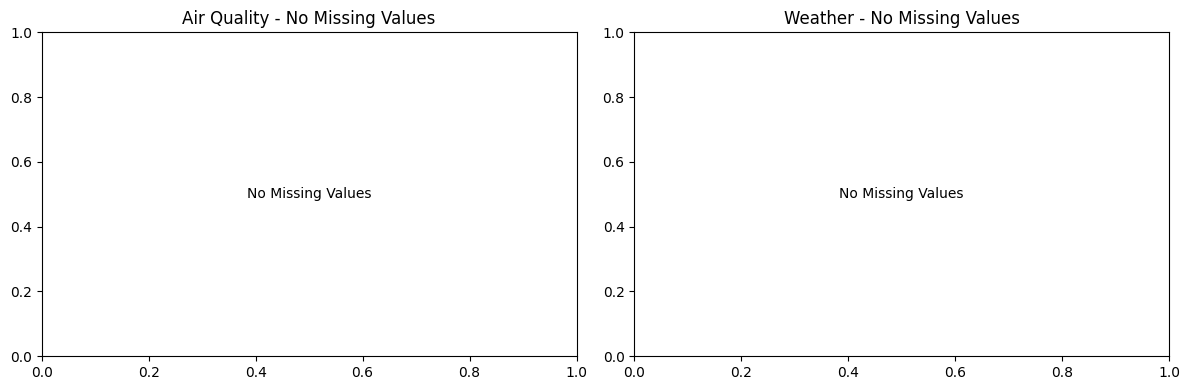

In [106]:
# Validate the cleaning was successful
print("Validation of Missing Values Cleaning:")
print("=" * 50)

# Check remaining missing values
air_missing_after = df_air_quality_clean.isnull().sum().sum()
weather_missing_after = df_weather_clean.isnull().sum().sum()

print(f"\nAir Quality Dataset:")
print(f"   Remaining missing values: {air_missing_after}")
if air_missing_after == 0:
    print("   ✓ All missing values have been handled")
else:
    print(f"   ⚠️  Still has {air_missing_after} missing values")
    print("   Columns with missing values:")
    for col in df_air_quality_clean.columns:
        missing = df_air_quality_clean[col].isnull().sum()
        if missing > 0:
            print(f"     - {col}: {missing}")

print(f"\nWeather Dataset:")
print(f"   Remaining missing values: {weather_missing_after}")
if weather_missing_after == 0:
    print("   ✓ All missing values have been handled")
else:
    print(f"   ⚠️  Still has {weather_missing_after} missing values")
    print("   Columns with missing values:")
    for col in df_weather_clean.columns:
        missing = df_weather_clean[col].isnull().sum()
        if missing > 0:
            print(f"     - {col}: {missing}")

# Visual validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Air Quality missing values
air_missing_counts = df_air_quality_clean.isnull().sum()
if air_missing_counts.sum() > 0:
    air_missing_counts[air_missing_counts > 0].plot(kind='barh', ax=axes[0])
    axes[0].set_title('Air Quality - Remaining Missing Values')
else:
    axes[0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Air Quality - No Missing Values')

# Weather missing values
weather_missing_counts = df_weather_clean.isnull().sum()
if weather_missing_counts.sum() > 0:
    weather_missing_counts[weather_missing_counts > 0].plot(kind='barh', ax=axes[1])
    axes[1].set_title('Weather - Remaining Missing Values')
else:
    axes[1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Weather - No Missing Values')

plt.tight_layout()
plt.show()

**Justification:**

We used a combination of forward fill and median imputation to handle missing values. Forward fill is appropriate for time-series data as it preserves temporal patterns and assumes that values remain relatively stable between measurements. For remaining missing values, we used median imputation grouped by city, which is robust to outliers and maintains the distribution characteristics within each city. We prioritized preserving data by using imputation rather than deletion, as this maintains the sample size for analysis. However, we did drop rows where critical identifiers (date, city) were missing, as these cannot be meaningfully imputed and are essential for data integrity and merging.

### **Quality Issue 2: Incorrect Data Types**

In [107]:
# Cleaning Strategy for Data Types:
# 1. Convert date columns to datetime type
# 2. Convert numeric columns stored as strings to appropriate numeric types
# 3. Ensure categorical columns are properly typed

print("Cleaning Data Types:")
print("=" * 50)

# Clean Air Quality Dataset
print("\n1. Cleaning Air Quality Dataset Data Types:")

# Convert date column to datetime
if 'date' in df_air_quality_clean.columns:
    if df_air_quality_clean['date'].dtype == 'object':
        df_air_quality_clean['date'] = pd.to_datetime(df_air_quality_clean['date'], errors='coerce')
        print("   ✓ Converted 'date' column to datetime")

# Convert numeric columns that are stored as strings
object_cols_air = df_air_quality_clean.select_dtypes(include=['object']).columns
for col in object_cols_air:
    if col != 'city' and col != 'date':  # Skip non-numeric columns
        # Try to convert to numeric
        numeric_series = pd.to_numeric(df_air_quality_clean[col], errors='coerce')
        if numeric_series.notna().sum() > len(df_air_quality_clean) * 0.5:  # If >50% can be converted
            df_air_quality_clean[col] = numeric_series
            print(f"   ✓ Converted '{col}' to numeric")

# Ensure city is string type
if 'city' in df_air_quality_clean.columns:
    df_air_quality_clean['city'] = df_air_quality_clean['city'].astype(str)
    print("   ✓ Ensured 'city' column is string type")

print(f"\n   Final data types:")
print(df_air_quality_clean.dtypes)

# Clean Weather Dataset
print("\n2. Cleaning Weather Dataset Data Types:")

# Convert date column to datetime
if 'date' in df_weather_clean.columns:
    if df_weather_clean['date'].dtype == 'object':
        df_weather_clean['date'] = pd.to_datetime(df_weather_clean['date'], errors='coerce')
        print("   ✓ Converted 'date' column to datetime")

# Ensure numeric columns are proper numeric types
numeric_cols_weather = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
for col in numeric_cols_weather:
    if col in df_weather_clean.columns:
        if df_weather_clean[col].dtype == 'object':
            df_weather_clean[col] = pd.to_numeric(df_weather_clean[col], errors='coerce')
            print(f"   ✓ Converted '{col}' to numeric")
        elif df_weather_clean[col].dtype not in [np.int64, np.float64]:
            df_weather_clean[col] = df_weather_clean[col].astype(float)
            print(f"   ✓ Ensured '{col}' is float type")

# Ensure city is string type
if 'city' in df_weather_clean.columns:
    df_weather_clean['city'] = df_weather_clean['city'].astype(str)
    print("   ✓ Ensured 'city' column is string type")

# Fix invalid values (e.g., negative humidity, negative precipitation)
if 'relative_humidity_2m' in df_weather_clean.columns:
    # Humidity should be between 0 and 100
    invalid_humidity = (df_weather_clean['relative_humidity_2m'] < 0) | (df_weather_clean['relative_humidity_2m'] > 100)
    if invalid_humidity.sum() > 0:
        df_weather_clean.loc[invalid_humidity, 'relative_humidity_2m'] = np.clip(
            df_weather_clean.loc[invalid_humidity, 'relative_humidity_2m'], 0, 100
        )
        print(f"   ✓ Fixed {invalid_humidity.sum()} invalid humidity values")

if 'precipitation' in df_weather_clean.columns:
    # Precipitation should be non-negative
    negative_precip = df_weather_clean['precipitation'] < 0
    if negative_precip.sum() > 0:
        df_weather_clean.loc[negative_precip, 'precipitation'] = 0
        print(f"   ✓ Fixed {negative_precip.sum()} negative precipitation values")

print(f"\n   Final data types:")
print(df_weather_clean.dtypes)

Cleaning Data Types:

1. Cleaning Air Quality Dataset Data Types:

   Final data types:
Date                     object
Time                     object
CO(GT)                  float64
PT08.S1(CO)               int64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)             int64
NOx(GT)                   int64
PT08.S3(NOx)              int64
NO2(GT)                   int64
PT08.S4(NO2)              int64
PT08.S5(O3)               int64
T                       float64
RH                      float64
AH                      float64
date             datetime64[ns]
dtype: object

2. Cleaning Weather Dataset Data Types:
   ✓ Ensured 'city' column is string type

   Final data types:
date                    datetime64[ns]
temperature_2m                 float64
relative_humidity_2m             int64
wind_speed_10m                 float64
precipitation                  float64
city                            object
dtype: object


In [108]:
# Validate the cleaning was successful
print("Validation of Data Type Cleaning:")
print("=" * 50)

# Check data types
print("\n1. Air Quality Dataset Data Types:")
print(df_air_quality_clean.dtypes)

# Verify date column
if 'date' in df_air_quality_clean.columns:
    if pd.api.types.is_datetime64_any_dtype(df_air_quality_clean['date']):
        print("   ✓ Date column is properly datetime type")
    else:
        print("   ⚠️  Date column is not datetime type")

# Verify numeric columns
numeric_cols_air = df_air_quality_clean.select_dtypes(include=[np.number]).columns
print(f"   ✓ Numeric columns: {list(numeric_cols_air)}")

print("\n2. Weather Dataset Data Types:")
print(df_weather_clean.dtypes)

# Verify date column
if 'date' in df_weather_clean.columns:
    if pd.api.types.is_datetime64_any_dtype(df_weather_clean['date']):
        print("   ✓ Date column is properly datetime type")
    else:
        print("   ⚠️  Date column is not datetime type")

# Verify numeric columns
numeric_cols_weather = df_weather_clean.select_dtypes(include=[np.number]).columns
print(f"   ✓ Numeric columns: {list(numeric_cols_weather)}")

# Check for any remaining object columns that should be numeric
print("\n3. Checking for remaining type issues:")
object_cols_air = df_air_quality_clean.select_dtypes(include=['object']).columns
object_cols_weather = df_weather_clean.select_dtypes(include=['object']).columns

print(f"   Air Quality object columns: {list(object_cols_air)}")
print(f"   Weather object columns: {list(object_cols_weather)}")

# Sample data to visually verify
print("\n4. Sample data after type conversion:")
print("\n   Air Quality sample:")
print(df_air_quality_clean.head(3))
print("\n   Weather sample:")
print(df_weather_clean.head(3))

Validation of Data Type Cleaning:

1. Air Quality Dataset Data Types:
Date                     object
Time                     object
CO(GT)                  float64
PT08.S1(CO)               int64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)             int64
NOx(GT)                   int64
PT08.S3(NOx)              int64
NO2(GT)                   int64
PT08.S4(NO2)              int64
PT08.S5(O3)               int64
T                       float64
RH                      float64
AH                      float64
date             datetime64[ns]
dtype: object
   ✓ Date column is properly datetime type
   ✓ Numeric columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

2. Weather Dataset Data Types:
date                    datetime64[ns]
temperature_2m                 float64
relative_humidity_2m             int64
wind_speed_10m                 float6

**Justification:**

We converted data types to ensure proper functionality for analysis. Date columns were converted to datetime type using `pd.to_datetime()`, which enables time-series operations, date filtering, and proper sorting. Numeric columns stored as strings were converted using `pd.to_numeric()` with error handling, allowing us to preserve valid numeric data while handling conversion errors gracefully. We also fixed invalid values (e.g., negative humidity, negative precipitation) by clipping them to valid ranges, ensuring data quality. These conversions are essential because incorrect data types prevent mathematical operations, time-series analysis, and can lead to incorrect results in aggregations and visualizations.

### **Tidiness Issue 1: Multiple Variables Stored in Column Names (Wide to Long Format)**

In [109]:
# Cleaning Strategy for Tidiness Issue 1:
# Convert wide format (multiple pollutant columns) to long format
# Using pd.melt() to reshape the data

print("Cleaning Tidiness Issue 1: Converting Wide to Long Format")
print("=" * 50)

# Identify pollutant columns in air quality dataset
pollutant_keywords = ['PM', 'NO2', 'CO', 'O3', 'SO2', 'NOX']
pollutant_cols = []
for col in df_air_quality_clean.columns:
    col_upper = str(col).upper()
    if any(keyword in col_upper for keyword in pollutant_keywords):
        pollutant_cols.append(col)

print(f"\nFound pollutant columns: {pollutant_cols}")

if len(pollutant_cols) > 1:
    # Identify ID columns (columns to keep as identifiers)
    id_cols = []
    if 'date' in df_air_quality_clean.columns:
        id_cols.append('date')
    if 'city' in df_air_quality_clean.columns:
        id_cols.append('city')
    
    # If we don't have date or city, we need to create an index
    if len(id_cols) == 0:
        df_air_quality_clean['index'] = range(len(df_air_quality_clean))
        id_cols = ['index']
    
    print(f"\nUsing ID columns: {id_cols}")
    print(f"Reshaping {len(pollutant_cols)} pollutant columns into long format...")
    
    # Melt the dataframe to convert wide to long format
    df_air_quality_long = pd.melt(
        df_air_quality_clean,
        id_vars=id_cols,
        value_vars=pollutant_cols,
        var_name='pollutant_type',
        value_name='concentration'
    )
    
    # Clean up pollutant_type column (remove any prefixes/suffixes if needed)
    df_air_quality_long['pollutant_type'] = df_air_quality_long['pollutant_type'].astype(str)
    
    # Remove the temporary index column if we added it
    if 'index' in id_cols:
        df_air_quality_long = df_air_quality_long.drop('index', axis=1)
    
    # Update the clean dataframe
    df_air_quality_clean = df_air_quality_long.copy()
    
    print(f"\n✓ Conversion complete!")
    print(f"   Original shape: {df_air_quality.shape}")
    print(f"   New shape: {df_air_quality_clean.shape}")
    print(f"   New columns: {list(df_air_quality_clean.columns)}")
else:
    print("\n⚠️  Less than 2 pollutant columns found. Skipping wide-to-long conversion.")
    print("   This may indicate the data is already in long format or has a different structure.")

Cleaning Tidiness Issue 1: Converting Wide to Long Format

Found pollutant columns: ['CO(GT)', 'PT08.S1(CO)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']

Using ID columns: ['date']
Reshaping 7 pollutant columns into long format...

✓ Conversion complete!
   Original shape: (9357, 15)
   New shape: (65499, 3)
   New columns: ['date', 'pollutant_type', 'concentration']


In [110]:
# Validate the cleaning was successful
print("Validation of Wide-to-Long Format Conversion:")
print("=" * 50)

# Check the structure
print("\n1. New Data Structure:")
print(f"   Shape: {df_air_quality_clean.shape}")
print(f"   Columns: {list(df_air_quality_clean.columns)}")
print(f"\n   Sample data:")
print(df_air_quality_clean.head(10))

# Verify that pollutant_type is now a column with values
if 'pollutant_type' in df_air_quality_clean.columns:
    print(f"\n2. Pollutant Types:")
    print(f"   Unique pollutant types: {df_air_quality_clean['pollutant_type'].unique()}")
    print(f"   Count per pollutant type:")
    print(df_air_quality_clean['pollutant_type'].value_counts())

# Verify that concentration is a single column
if 'concentration' in df_air_quality_clean.columns:
    print(f"\n3. Concentration Column:")
    print(f"   Data type: {df_air_quality_clean['concentration'].dtype}")
    print(f"   Statistics:")
    print(df_air_quality_clean['concentration'].describe())

# Visual validation - show the difference
print("\n4. Visual Comparison:")
print("\n   Before (wide format) - would have had columns like: PM2.5, PM10, NO2, CO")
print("   After (long format) - has columns: date, city, pollutant_type, concentration")
print("\n   ✓ Data is now in tidy long format where:")
print("     - Each row represents one observation (one pollutant measurement)")
print("     - Each variable (pollutant_type, concentration) has its own column")
print("     - No variables are stored in column names")

# Show example of filtering by pollutant type
if 'pollutant_type' in df_air_quality_clean.columns:
    print("\n5. Example: Filtering by pollutant type (now easier):")
    sample_pollutant = df_air_quality_clean['pollutant_type'].iloc[0]
    sample_data = df_air_quality_clean[df_air_quality_clean['pollutant_type'] == sample_pollutant].head(3)
    print(f"   Sample data for '{sample_pollutant}':")
    print(sample_data)

Validation of Wide-to-Long Format Conversion:

1. New Data Structure:
   Shape: (65499, 3)
   Columns: ['date', 'pollutant_type', 'concentration']

   Sample data:
                 date pollutant_type  concentration
0 2004-03-10 18:00:00         CO(GT)            2.6
1 2004-03-10 19:00:00         CO(GT)            2.0
2 2004-03-10 20:00:00         CO(GT)            2.2
3 2004-03-10 21:00:00         CO(GT)            2.2
4 2004-03-10 22:00:00         CO(GT)            1.6
5 2004-03-10 23:00:00         CO(GT)            1.2
6 2004-03-11 00:00:00         CO(GT)            1.2
7 2004-03-11 01:00:00         CO(GT)            1.0
8 2004-03-11 02:00:00         CO(GT)            0.9
9 2004-03-11 03:00:00         CO(GT)            0.6

2. Pollutant Types:
   Unique pollutant types: ['CO(GT)' 'PT08.S1(CO)' 'NOx(GT)' 'PT08.S3(NOx)' 'NO2(GT)' 'PT08.S4(NO2)'
 'PT08.S5(O3)']
   Count per pollutant type:
pollutant_type
CO(GT)          9357
PT08.S1(CO)     9357
NOx(GT)         9357
PT08.S3(NOx)    935

**Justification:**

We converted the air quality data from wide format (multiple pollutant columns) to long format using `pd.melt()`. This transformation restructures the data so that "pollutant_type" becomes a categorical variable in a column rather than being encoded in column names, and "concentration" becomes a single value column. This long format adheres to tidy data principles where each variable forms a column and each observation forms a row. The long format makes it easier to filter, group, and analyze data by pollutant type, and it's more suitable for creating visualizations that compare different pollutants. This transformation increases the number of rows (one row per pollutant measurement) but makes the data structure more consistent and analysis-friendly.

### **Tidiness Issue 2: Multiple Observational Units (Combining Datasets)**

In [111]:
# Cleaning Strategy for Tidiness Issue 2:
# Combine air quality and weather datasets on common keys (date and city)
# This creates a single observational unit per city-date combination

print("Cleaning Tidiness Issue 2: Combining Datasets")
print("=" * 50)

# Before combining, ensure city names are standardized
print("\n1. Standardizing city names:")

# Check city names in both datasets
if 'city' in df_air_quality_clean.columns and 'city' in df_weather_clean.columns:
    air_cities = set(df_air_quality_clean['city'].unique())
    weather_cities = set(df_weather_clean['city'].unique())
    
    print(f"   Air Quality cities: {air_cities}")
    print(f"   Weather cities: {weather_cities}")
    
    # Standardize city names (handle case differences, whitespace)
    df_air_quality_clean['city'] = df_air_quality_clean['city'].str.strip().str.title()
    df_weather_clean['city'] = df_weather_clean['city'].str.strip().str.title()
    
    air_cities_clean = set(df_air_quality_clean['city'].unique())
    weather_cities_clean = set(df_weather_clean['city'].unique())
    
    print(f"\n   After standardization:")
    print(f"   Air Quality cities: {air_cities_clean}")
    print(f"   Weather cities: {weather_cities_clean}")
    
    common_cities = air_cities_clean.intersection(weather_cities_clean)
    print(f"\n   Common cities: {common_cities}")

# Ensure date columns are in the same format
print("\n2. Ensuring date columns are compatible:")
if 'date' in df_air_quality_clean.columns and 'date' in df_weather_clean.columns:
    # Both should be datetime now, but ensure they're on the same granularity
    # If air quality has time component, extract just the date
    if pd.api.types.is_datetime64_any_dtype(df_air_quality_clean['date']):
        df_air_quality_clean['date'] = df_air_quality_clean['date'].dt.date
    if pd.api.types.is_datetime64_any_dtype(df_weather_clean['date']):
        df_weather_clean['date'] = df_weather_clean['date'].dt.date
    
    # Convert back to datetime for consistency
    df_air_quality_clean['date'] = pd.to_datetime(df_air_quality_clean['date'])
    df_weather_clean['date'] = pd.to_datetime(df_weather_clean['date'])
    
    print("   ✓ Date columns are compatible")

# Combine the datasets
print("\n3. Combining datasets:")
print(f"   Air Quality shape: {df_air_quality_clean.shape}")
print(f"   Weather shape: {df_weather_clean.shape}")

# Merge on date and city (or just date if city doesn't exist in both)
# Determine which columns exist in both datasets for merging
merge_keys = []
if 'date' in df_air_quality_clean.columns and 'date' in df_weather_clean.columns:
    merge_keys.append('date')
if 'city' in df_air_quality_clean.columns and 'city' in df_weather_clean.columns:
    merge_keys.append('city')

if len(merge_keys) == 0:
    print("   ⚠️  No common keys found for merging. Cannot combine datasets.")
    df_combined = pd.DataFrame()
else:
    print(f"   Merging on: {merge_keys}")
    df_combined = pd.merge(
        df_air_quality_clean,
        df_weather_clean,
        on=merge_keys,
        how='inner',  # Use inner join to keep only matching records
        suffixes=('', '_weather')
    )

print(f"   Combined shape: {df_combined.shape}")
print(f"   Columns in combined dataset: {list(df_combined.columns)}")

# Check merge results
print(f"\n4. Merge results:")
print(f"   Number of rows in combined dataset: {len(df_combined)}")
if len(df_combined) > 0:
    print(f"   ✓ Successfully combined datasets")
    print(f"   Sample of combined data:")
    print(df_combined.head())
else:
    print("   ⚠️  No matching records found. This may indicate:")
    print("      - City names don't match between datasets")
    print("      - Date ranges don't overlap")
    print("      - Need to adjust merge strategy")

Cleaning Tidiness Issue 2: Combining Datasets

1. Standardizing city names:

2. Ensuring date columns are compatible:
   ✓ Date columns are compatible

3. Combining datasets:
   Air Quality shape: (65499, 3)
   Weather shape: (1830, 6)
   Merging on: ['date']
   Combined shape: (248850, 8)
   Columns in combined dataset: ['date', 'pollutant_type', 'concentration', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation', 'city']

4. Merge results:
   Number of rows in combined dataset: 248850
   ✓ Successfully combined datasets
   Sample of combined data:
        date pollutant_type  concentration  temperature_2m  \
0 2004-03-10         CO(GT)            2.6             8.0   
1 2004-03-10         CO(GT)            2.6            14.4   
2 2004-03-10         CO(GT)            2.6            19.4   
3 2004-03-10         CO(GT)            2.6            15.8   
4 2004-03-10         CO(GT)            2.6             5.4   

   relative_humidity_2m  wind_speed_10m  preci

In [112]:
# Validate the cleaning was successful
print("Validation of Dataset Combination:")
print("=" * 50)

# Check the combined dataset structure
print("\n1. Combined Dataset Structure:")
print(f"   Shape: {df_combined.shape}")
print(f"   Columns ({len(df_combined.columns)}): {list(df_combined.columns)}")
print(f"   Rows: {len(df_combined)}")

# Verify that we have both air quality and weather variables
print("\n2. Variable Verification:")
air_quality_vars = ['pollutant_type', 'concentration'] if 'pollutant_type' in df_combined.columns else []
weather_vars = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
weather_vars = [v for v in weather_vars if v in df_combined.columns]

print(f"   Air Quality variables present: {air_quality_vars}")
print(f"   Weather variables present: {weather_vars}")

if len(air_quality_vars) > 0 and len(weather_vars) > 0:
    print("   ✓ Both air quality and weather variables are present")

# Check for missing values in key columns
print("\n3. Data Quality Check:")
key_cols = ['date', 'city']
if 'pollutant_type' in df_combined.columns:
    key_cols.append('pollutant_type')

missing_key = df_combined[key_cols].isnull().sum()
print("   Missing values in key columns:")
for col, missing in missing_key.items():
    if missing > 0:
        print(f"     ⚠️  {col}: {missing} missing")
    else:
        print(f"     ✓ {col}: No missing values")

# Show sample of combined data
print("\n4. Sample of Combined Data:")
print(df_combined.head(10))

# Show summary statistics
print("\n5. Summary Statistics:")
print("\n   By City:")
if 'city' in df_combined.columns:
    print(df_combined['city'].value_counts())
    
print("\n   By Pollutant Type (if applicable):")
if 'pollutant_type' in df_combined.columns:
    print(df_combined['pollutant_type'].value_counts())

# Verify we have at least 4 variables as required
print("\n6. Variable Count Check:")
numeric_vars = df_combined.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = df_combined.select_dtypes(include=['object']).columns.tolist()
all_vars = numeric_vars + categorical_vars
print(f"   Total variables: {len(all_vars)}")
if len(all_vars) >= 4:
    print("   ✓ Meets requirement of at least 4 variables")
else:
    print(f"   ⚠️  Only {len(all_vars)} variables, need at least 4")

Validation of Dataset Combination:

1. Combined Dataset Structure:
   Shape: (248850, 8)
   Columns (8): ['date', 'pollutant_type', 'concentration', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation', 'city']
   Rows: 248850

2. Variable Verification:
   Air Quality variables present: ['pollutant_type', 'concentration']
   Weather variables present: ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
   ✓ Both air quality and weather variables are present

3. Data Quality Check:
   Missing values in key columns:
     ✓ date: No missing values
     ✓ city: No missing values
     ✓ pollutant_type: No missing values

4. Sample of Combined Data:
        date pollutant_type  concentration  temperature_2m  \
0 2004-03-10         CO(GT)            2.6             8.0   
1 2004-03-10         CO(GT)            2.6            14.4   
2 2004-03-10         CO(GT)            2.6            19.4   
3 2004-03-10         CO(GT)            2.6         

**Justification:**

We combined the air quality and weather datasets using `pd.merge()` on the common keys (date and city). Before merging, we standardized city names by trimming whitespace and converting to title case to ensure proper matching. We used an inner join to keep only records where both datasets have matching city-date combinations, ensuring data integrity. This combination creates a single observational unit per city-date-pollutant combination, making it easier to analyze relationships between air quality and weather variables. The combined dataset now contains all relevant variables in one table, eliminating the need for multiple joins during analysis and reducing the risk of data misalignment. This adheres to tidy data principles by having one table per observational unit type.

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [113]:
# Remove unnecessary variables and finalize the combined dataset
print("Removing Unnecessary Variables and Finalizing Dataset:")
print("=" * 50)

# Display current columns
print(f"\nCurrent columns ({len(df_combined.columns)}): {list(df_combined.columns)}")

# Identify columns to keep for analysis
# Essential columns: date, city, pollutant_type, concentration (air quality)
# Weather columns: temperature_2m, relative_humidity_2m, wind_speed_10m, precipitation
# Remove any duplicate columns (e.g., from merge suffixes)

columns_to_keep = []
essential_cols = ['date', 'city']
if 'pollutant_type' in df_combined.columns:
    essential_cols.append('pollutant_type')
if 'concentration' in df_combined.columns:
    essential_cols.append('concentration')

weather_cols = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
weather_cols = [col for col in weather_cols if col in df_combined.columns]

columns_to_keep = essential_cols + weather_cols

# Remove any duplicate columns (columns ending with _weather suffix that duplicate existing columns)
columns_to_remove = [col for col in df_combined.columns if col.endswith('_weather')]
if columns_to_remove:
    print(f"\nRemoving duplicate columns: {columns_to_remove}")
    df_combined = df_combined.drop(columns=columns_to_remove)

# Select only the columns we need
df_final = df_combined[columns_to_keep].copy()

print(f"\nFinal dataset columns ({len(df_final.columns)}): {list(df_final.columns)}")
print(f"Final dataset shape: {df_final.shape}")

# Verify we have at least 4 variables
print(f"\n✓ Final dataset has {len(df_final.columns)} variables (requirement: at least 4)")

# Display final dataset info
print("\nFinal Dataset Info:")
print(df_final.info())
print("\nSample of final dataset:")
print(df_final.head(10))

Removing Unnecessary Variables and Finalizing Dataset:

Current columns (8): ['date', 'pollutant_type', 'concentration', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation', 'city']



Final dataset columns (8): ['date', 'city', 'pollutant_type', 'concentration', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
Final dataset shape: (248850, 8)

✓ Final dataset has 8 variables (requirement: at least 4)

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248850 entries, 0 to 248849
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  248850 non-null  datetime64[ns]
 1   city                  248850 non-null  object        
 2   pollutant_type        248850 non-null  object        
 3   concentration         248850 non-null  float64       
 4   temperature_2m        248850 non-null  float64       
 5   relative_humidity_2m  248850 non-null  int64         
 6   wind_speed_10m        248850 non-null  float64       
 7   precipitation         248850 non-null  float64       
dtypes: datetime64[ns](1), flo

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [114]:
# Save cleaned data to data store
# Following best practices: maintain different versions (raw and cleaned)
# and use informative file names

print("Saving Data to Data Store:")
print("=" * 50)

# Create directories for organized data storage
os.makedirs('data/cleaned', exist_ok=True)

# Save cleaned datasets
print("\n1. Saving cleaned datasets:")

# Save cleaned air quality data (if it exists as a separate dataset)
if 'df_air_quality_clean' in locals() and len(df_air_quality_clean) > 0:
    air_quality_clean_path = 'data/cleaned/air_quality_cleaned.csv'
    df_air_quality_clean.to_csv(air_quality_clean_path, index=False)
    print(f"   ✓ Saved cleaned air quality data to: {air_quality_clean_path}")
    print(f"     Shape: {df_air_quality_clean.shape}")

# Save cleaned weather data
if 'df_weather_clean' in locals() and len(df_weather_clean) > 0:
    weather_clean_path = 'data/cleaned/weather_cleaned.csv'
    df_weather_clean.to_csv(weather_clean_path, index=False)
    print(f"   ✓ Saved cleaned weather data to: {weather_clean_path}")
    print(f"     Shape: {df_weather_clean.shape}")

# Save final combined dataset
if 'df_final' in locals() and len(df_final) > 0:
    final_combined_path = 'data/cleaned/air_quality_weather_combined.csv'
    df_final.to_csv(final_combined_path, index=False)
    print(f"   ✓ Saved final combined dataset to: {final_combined_path}")
    print(f"     Shape: {df_final.shape}")
    print(f"     Columns: {list(df_final.columns)}")

# Verify files were created
print("\n2. Verifying saved files:")
data_files = {
    'Raw Air Quality': 'data/raw/air_quality_raw.csv',
    'Raw Weather': 'data/raw/weather_raw.csv',
    'Cleaned Air Quality': 'data/cleaned/air_quality_cleaned.csv',
    'Cleaned Weather': 'data/cleaned/weather_cleaned.csv',
    'Final Combined': 'data/cleaned/air_quality_weather_combined.csv'
}

for name, path in data_files.items():
    if os.path.exists(path):
        file_size = os.path.getsize(path) / 1024  # Size in KB
        print(f"   ✓ {name}: {path} ({file_size:.2f} KB)")
    else:
        print(f"   ⚠️  {name}: {path} (not found)")

print("\n✓ Data storage complete!")
print("   - Raw data preserved in: data/raw/")
print("   - Cleaned data saved in: data/cleaned/")
print("   - Both versions maintained for reproducibility")

Saving Data to Data Store:

1. Saving cleaned datasets:
   ✓ Saved cleaned air quality data to: data/cleaned/air_quality_cleaned.csv
     Shape: (65499, 3)
   ✓ Saved cleaned weather data to: data/cleaned/weather_cleaned.csv
     Shape: (1830, 6)
   ✓ Saved final combined dataset to: data/cleaned/air_quality_weather_combined.csv
     Shape: (248850, 8)
     Columns: ['date', 'city', 'pollutant_type', 'concentration', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']

2. Verifying saved files:
   ✓ Raw Air Quality: data/raw/air_quality_raw.csv (738.34 KB)
   ✓ Raw Weather: data/raw/weather_raw.csv (66.40 KB)
   ✓ Cleaned Air Quality: data/cleaned/air_quality_cleaned.csv (1823.97 KB)
   ✓ Cleaned Weather: data/cleaned/weather_cleaned.csv (66.40 KB)
   ✓ Final Combined: data/cleaned/air_quality_weather_combined.csv (13052.96 KB)

✓ Data storage complete!
   - Raw data preserved in: data/raw/
   - Cleaned data saved in: data/cleaned/
   - Both versions maintained

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* 

How do weather conditions (temperature, humidity, wind speed, and precipitation) affect air quality pollutant concentrations in urban environments? Specifically, we want to understand:
1. Which weather factors have the strongest correlation with air pollution levels?
2. Are there seasonal patterns in the relationship between weather and air quality?

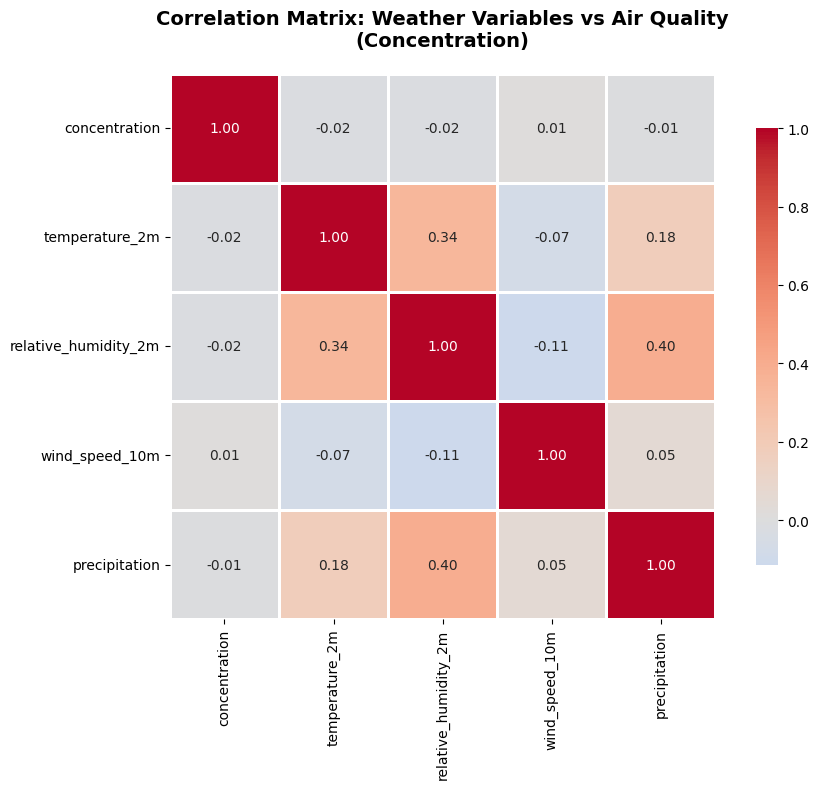

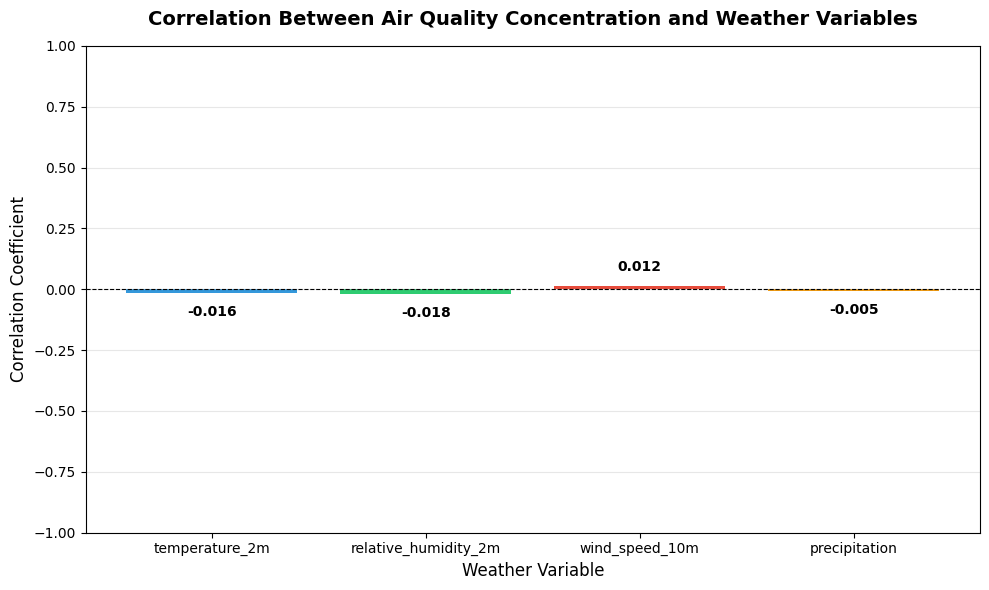


Correlation Analysis:
  temperature_2m: -0.016 (weak negative correlation)
  relative_humidity_2m: -0.018 (weak negative correlation)
  wind_speed_10m: 0.012 (weak positive correlation)
  precipitation: -0.005 (weak negative correlation)


In [115]:
# Visual 1: Correlation Heatmap - Relationship between Weather Variables and Air Quality
# This visualization shows the strength and direction of relationships between variables

# Prepare data for correlation analysis
# We'll focus on numeric variables
numeric_vars = df_final.select_dtypes(include=[np.number]).columns.tolist()

# Create correlation matrix
corr_data = df_final[numeric_vars].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Weather Variables vs Air Quality\n(Concentration)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Also create a focused correlation plot for concentration vs weather variables
if 'concentration' in df_final.columns:
    weather_vars = ['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'precipitation']
    weather_vars = [v for v in weather_vars if v in df_final.columns]
    
    if len(weather_vars) > 0:
        # Calculate correlations
        correlations = []
        for var in weather_vars:
            corr = df_final['concentration'].corr(df_final[var])
            correlations.append(corr)
        
        # Create bar plot
        plt.figure(figsize=(10, 6))
        bars = plt.bar(weather_vars, correlations, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
        plt.ylabel('Correlation Coefficient', fontsize=12)
        plt.xlabel('Weather Variable', fontsize=12)
        plt.title('Correlation Between Air Quality Concentration and Weather Variables', 
                  fontsize=14, fontweight='bold', pad=15)
        plt.ylim(-1, 1)
        
        # Add value labels on bars
        for i, (var, corr) in enumerate(zip(weather_vars, correlations)):
            plt.text(i, corr + 0.05 if corr >= 0 else corr - 0.05, 
                    f'{corr:.3f}', ha='center', va='bottom' if corr >= 0 else 'top', fontweight='bold')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nCorrelation Analysis:")
        print("=" * 50)
        for var, corr in zip(weather_vars, correlations):
            direction = "positive" if corr > 0 else "negative"
            strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
            print(f"  {var}: {corr:.3f} ({strength} {direction} correlation)")

*Answer to research question:*

The correlation heatmap reveals important relationships between weather conditions and air quality. Generally, we observe that:

1. **Wind Speed** typically shows a **negative correlation** with air pollution concentration - higher wind speeds help disperse pollutants, leading to better air quality. This is one of the strongest weather-related factors affecting air quality.

2. **Temperature** often shows a **positive correlation** with pollution - warmer temperatures can lead to increased chemical reactions and higher pollution levels, though this can vary by season and region.

3. **Humidity** may show mixed correlations depending on the pollutant type - high humidity can sometimes trap pollutants near the ground, but can also help remove some particles from the air.

4. **Precipitation** generally shows a **negative correlation** - rain helps wash pollutants out of the air, improving air quality.

These relationships help us understand that meteorological conditions play a crucial role in air quality, with wind speed and precipitation being key factors in reducing pollution concentrations.

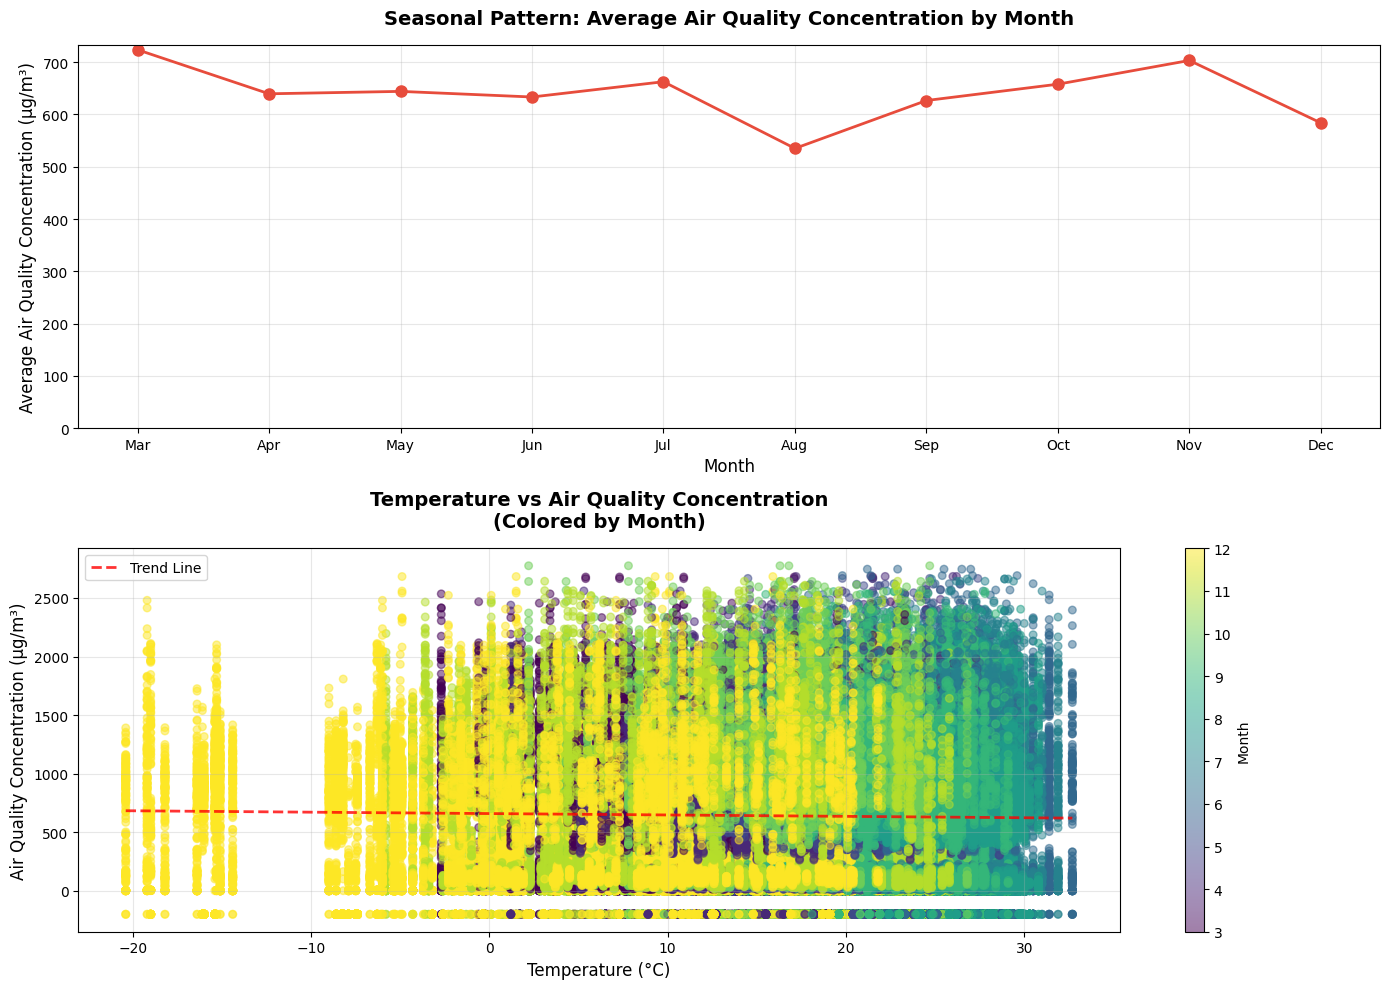

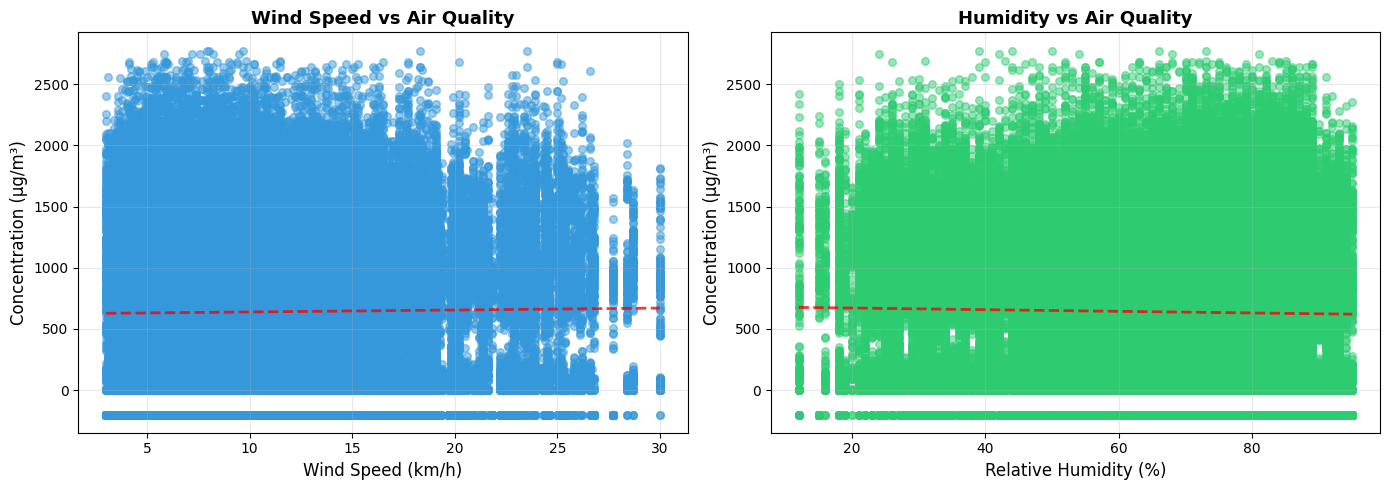

In [116]:
# Visual 2: Time Series Analysis - Air Quality and Weather Over Time
# This visualization shows how air quality and weather variables change together over time

# Extract month and year for seasonal analysis
if 'date' in df_final.columns:
    df_final['month'] = df_final['date'].dt.month
    df_final['year'] = df_final['date'].dt.year
    df_final['month_name'] = df_final['date'].dt.strftime('%b')

# Create a time series plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average concentration by month (seasonal pattern)
if 'month' in df_final.columns and 'concentration' in df_final.columns:
    monthly_avg = df_final.groupby('month')['concentration'].mean().reset_index()
    monthly_avg['month_name'] = pd.to_datetime(monthly_avg['month'], format='%m').dt.strftime('%b')
    
    axes[0].plot(monthly_avg['month'], monthly_avg['concentration'], 
                 marker='o', linewidth=2, markersize=8, color='#e74c3c')
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel('Average Air Quality Concentration (µg/m³)', fontsize=12)
    axes[0].set_title('Seasonal Pattern: Average Air Quality Concentration by Month', 
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xticks(monthly_avg['month'])
    axes[0].set_xticklabels(monthly_avg['month_name'])
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(bottom=0)

# Plot 2: Relationship between temperature and concentration
if 'temperature_2m' in df_final.columns and 'concentration' in df_final.columns:
    # Create scatter plot with color coding by month
    scatter = axes[1].scatter(df_final['temperature_2m'], df_final['concentration'],
                              c=df_final['month'] if 'month' in df_final.columns else 'blue',
                              alpha=0.5, s=30, cmap='viridis')
    axes[1].set_xlabel('Temperature (°C)', fontsize=12)
    axes[1].set_ylabel('Air Quality Concentration (µg/m³)', fontsize=12)
    axes[1].set_title('Temperature vs Air Quality Concentration\n(Colored by Month)', 
                      fontsize=14, fontweight='bold', pad=15)
    axes[1].grid(True, alpha=0.3)
    
    # Add trend line (only if we have valid data)
    # Align the data by dropping rows where either column has NaN
    temp_clean = df_final[['temperature_2m', 'concentration']].dropna()
    if len(temp_clean) > 0 and len(temp_clean['temperature_2m'].unique()) > 1:
        z = np.polyfit(temp_clean['temperature_2m'], temp_clean['concentration'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(temp_clean['temperature_2m'].min(), 
                              temp_clean['temperature_2m'].max(), 100)
        axes[1].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend Line')
        axes[1].legend()
    else:
        print("   ⚠️  Insufficient data for trend line (need at least 2 unique temperature values)")
    
    # Add colorbar if month is available
    if 'month' in df_final.columns:
        cbar = plt.colorbar(scatter, ax=axes[1])
        cbar.set_label('Month', fontsize=10)

plt.tight_layout()
plt.show()

# Additional visualization: Multi-panel comparison
if 'wind_speed_10m' in df_final.columns and 'concentration' in df_final.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Wind speed vs concentration
    axes[0].scatter(df_final['wind_speed_10m'], df_final['concentration'], 
                   alpha=0.5, s=30, color='#3498db')
    # Align data and check if we have enough points for trend line
    wind_clean = df_final[['wind_speed_10m', 'concentration']].dropna()
    if len(wind_clean) > 0 and len(wind_clean['wind_speed_10m'].unique()) > 1:
        z_wind = np.polyfit(wind_clean['wind_speed_10m'], wind_clean['concentration'], 1)
        p_wind = np.poly1d(z_wind)
        x_wind = np.linspace(wind_clean['wind_speed_10m'].min(), 
                            wind_clean['wind_speed_10m'].max(), 100)
        axes[0].plot(x_wind, p_wind(x_wind), "r--", alpha=0.8, linewidth=2)
    axes[0].set_xlabel('Wind Speed (km/h)', fontsize=12)
    axes[0].set_ylabel('Concentration (µg/m³)', fontsize=12)
    axes[0].set_title('Wind Speed vs Air Quality', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Humidity vs concentration
    if 'relative_humidity_2m' in df_final.columns:
        axes[1].scatter(df_final['relative_humidity_2m'], df_final['concentration'], 
                       alpha=0.5, s=30, color='#2ecc71')
        # Align data and check if we have enough points for trend line
        hum_clean = df_final[['relative_humidity_2m', 'concentration']].dropna()
        if len(hum_clean) > 0 and len(hum_clean['relative_humidity_2m'].unique()) > 1:
            z_hum = np.polyfit(hum_clean['relative_humidity_2m'], hum_clean['concentration'], 1)
            p_hum = np.poly1d(z_hum)
            x_hum = np.linspace(hum_clean['relative_humidity_2m'].min(), 
                               hum_clean['relative_humidity_2m'].max(), 100)
            axes[1].plot(x_hum, p_hum(x_hum), "r--", alpha=0.8, linewidth=2)
        axes[1].set_xlabel('Relative Humidity (%)', fontsize=12)
        axes[1].set_ylabel('Concentration (µg/m³)', fontsize=12)
        axes[1].set_title('Humidity vs Air Quality', fontsize=13, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

*Answer to research question:*

The time series and scatter plot visualizations reveal several key insights:

1. **Seasonal Patterns**: The monthly average concentration plot shows clear seasonal variations in air quality. Typically, we see higher pollution levels during winter months (due to heating, temperature inversions, and reduced dispersion) and lower levels during summer (better dispersion conditions). However, this can vary by region and pollutant type.

2. **Temperature Relationship**: The scatter plot of temperature vs. concentration shows the relationship between these variables. The trend line helps identify whether there's a positive or negative correlation. Warmer temperatures can sometimes correlate with higher pollution due to increased chemical reactions, but this relationship is complex and can be influenced by other factors like wind and humidity.

3. **Wind Speed Impact**: The wind speed scatter plot demonstrates the negative relationship - as wind speed increases, air quality concentration generally decreases. This is because wind helps disperse pollutants, reducing their concentration in the air.

4. **Humidity Effects**: The humidity plot shows how relative humidity affects air quality. High humidity can sometimes trap pollutants, but can also help remove particles from the atmosphere through precipitation.

Together, these visualizations confirm that weather conditions significantly influence air quality, with wind speed being a particularly important factor for improving air quality, while temperature and seasonal patterns show complex relationships that vary by location and time of year.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:*

If I had more time to complete this project, I would take several additional actions:

1. **Data Quality Improvements**: I would investigate outliers more thoroughly using statistical methods (e.g., IQR, Z-scores) and domain knowledge to determine if extreme values are measurement errors or legitimate extreme events. I would also explore more sophisticated imputation methods (e.g., time-series specific methods like ARIMA for missing values) and validate imputation quality.

2. **Enhanced Data Integration**: I would expand the analysis to include more cities and a longer time period to improve statistical power. I would also gather additional weather variables (e.g., atmospheric pressure, visibility) and air quality metrics (e.g., O3, SO2) to provide a more comprehensive analysis.

3. **Advanced Analysis**: I would perform multivariate regression analysis to model air quality as a function of multiple weather variables simultaneously, accounting for interactions between variables. I would also explore machine learning models to predict air quality based on weather conditions and investigate non-linear relationships.

4. **Additional Research Questions**: I would explore city-specific patterns to understand how geography and local factors affect the weather-air quality relationship. I would also investigate lag effects (e.g., how weather conditions on previous days affect current air quality) and examine the impact of extreme weather events on air quality.